Проведемо Exploratory Data Analysis на таблицях “application_{train|test}.csv”: про що ці дані, які розподіли колонок, скільки missing values, наскільки збалансовані дані, яким чином обробити missing values, чим відрізняються train/test, ...?

Ці дані відносяться до компанії Home Credit, яка прагне забезпечити фінансову інклюзію небанківських клієнтів, надаючи їм позитивний і безпечний досвід позики. Для оцінювання здатності клієнтів до повернення кредитів Home Credit використовує різноманітні альтернативні дані, включаючи інформацію від телекомунікаційних операторів та транзакційні дані. 

Розглянемо інформацію про дані application_train:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# Завантажуємо дані
data_train  = pd.read_csv('application_train.csv') 

# Переглянемо основну інформацію про датасет
print("Основна інформація про датасет:")
data_train .info()

Основна інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


# Наведемо графіки (гістограми) розподілів числових даних:

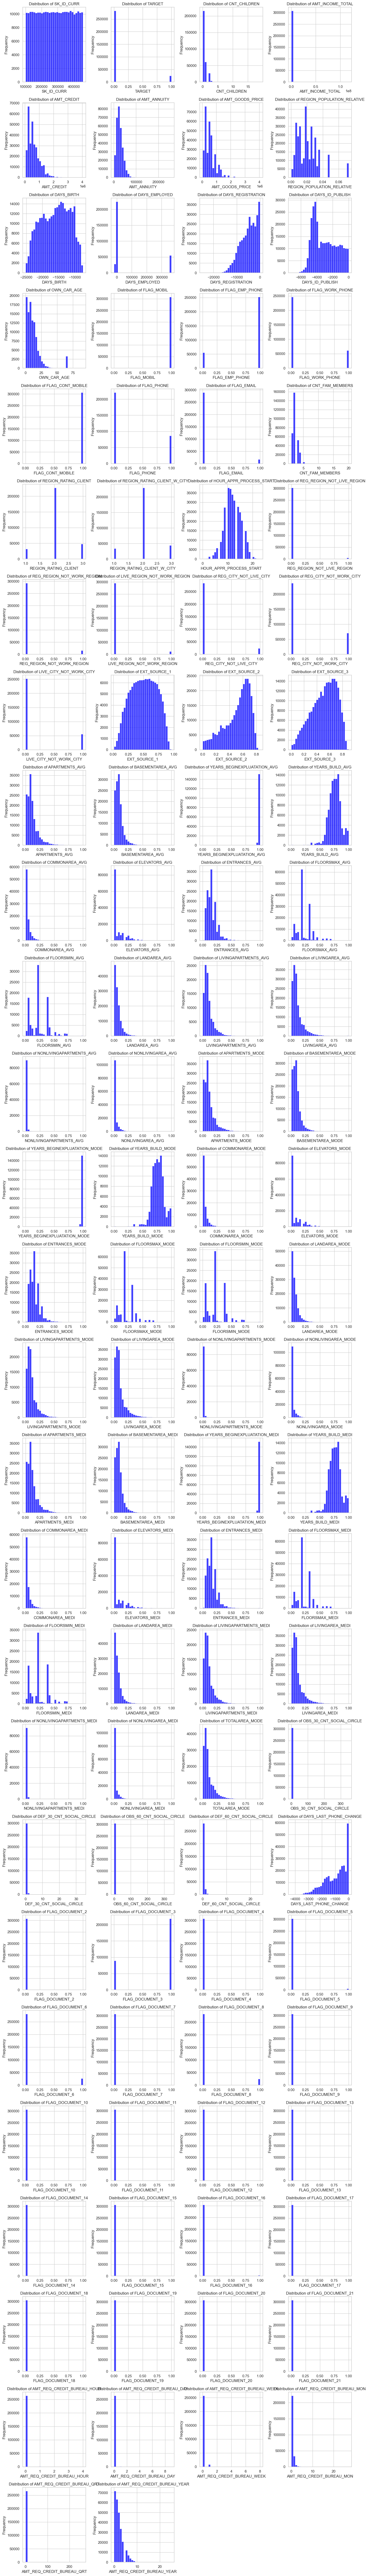

In [5]:
# Set the aesthetics for the plots
sns.set_theme(style="whitegrid")

# Determine the number of columns for numeric data_train  to create histograms
num_cols = data_train .select_dtypes(include=['float64', 'int64']).columns
num_plots = len(num_cols)
cols_per_row = 4
num_rows = num_plots // cols_per_row + (num_plots % cols_per_row > 0)  # Arrange plots in a grid of 6 columns

# Create a figure to hold the subplots
plt.figure(figsize=(15, num_rows * 4))

for index, col in enumerate(num_cols, 1):
    plt.subplot(num_rows, cols_per_row, index)
    sns.histplot(data_train [col].dropna(), kde=False, color='blue', bins=30)
    plt.title(f'Distribution of {col}')
    plt.ylabel('Frequency')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


## Наведемо графіки розподілу категоріальних даних

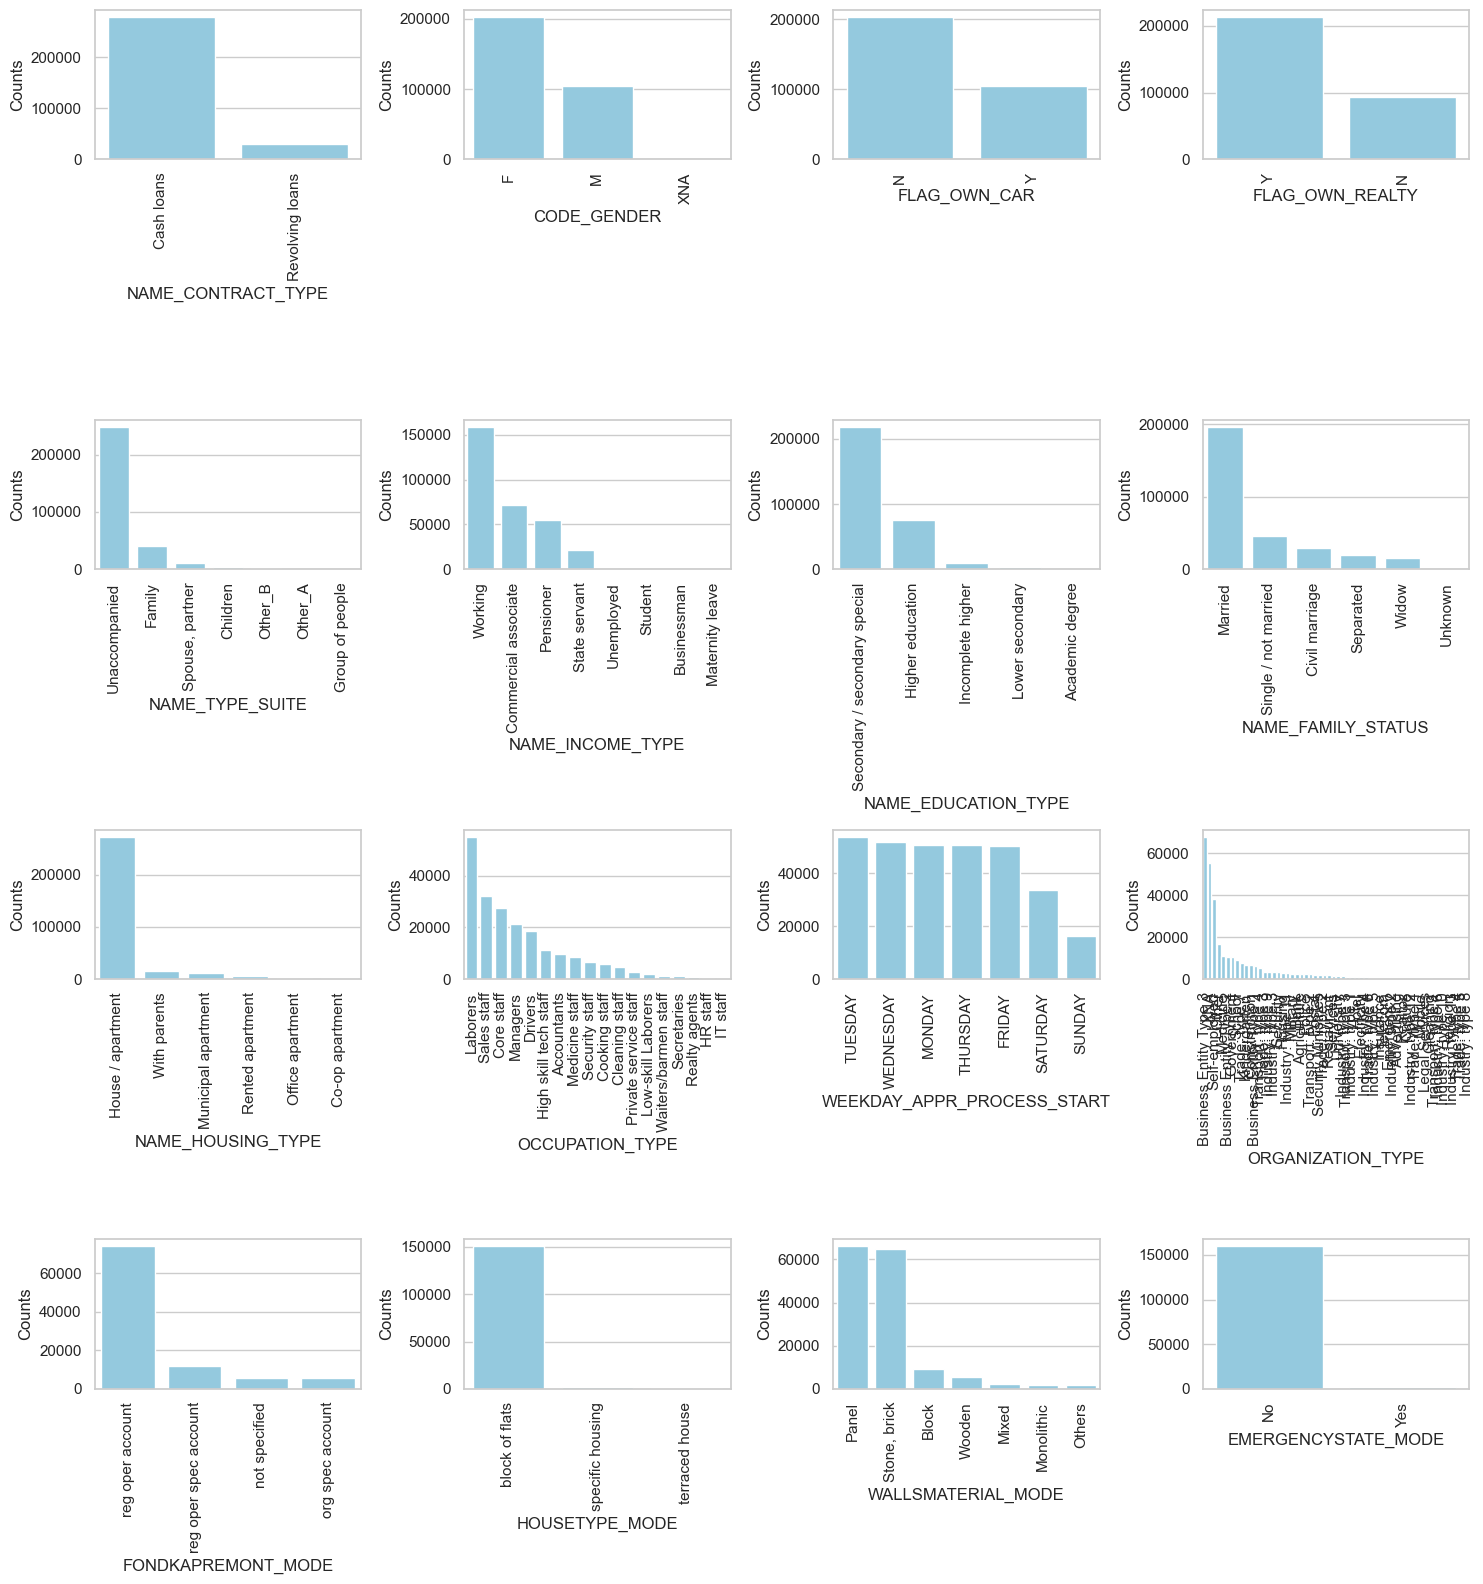

In [6]:
# Filter to get only non-numeric columns
cat_cols = data_train.select_dtypes(exclude=['float64', 'int64', 'int', 'float']).columns
num_plots = len(cat_cols)
cols_per_row = 4
num_rows = num_plots // cols_per_row + (num_plots % cols_per_row > 0)  # Arrange plots in a grid of cols_per_row columns

# Create a figure to hold the subplots
plt.figure(figsize=(15, num_rows * 4))

for index, col in enumerate(cat_cols, 1):
    plt.subplot(num_rows, cols_per_row, index)
    # Get value counts of the category data_train  and sort them
    cat_data = data_train [col].value_counts().sort_values(ascending=False)
    sns.barplot(x=cat_data.index, y=cat_data, color='skyblue')
    plt.xticks(rotation=90)  # Rotate category names for better visibility
    plt.ylabel('Counts')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


# Перевіримо кількість відсутніх значень у колонках


In [7]:

missing_values = data_train.isnull().sum()
print("Кількість відсутніх значень по кожному стовпцю:")
with pd.option_context('display.max_rows', None):
    print(missing_values[missing_values > 0])

Кількість відсутніх значень по кожному стовпцю:
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
OWN_CAR_AGE                     202929
OCCUPATION_TYPE                  96391
CNT_FAM_MEMBERS                      2
EXT_SOURCE_1                    173378
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
APARTMENTS_AVG                  156061
BASEMENTAREA_AVG                179943
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BUILD_AVG                 204488
COMMONAREA_AVG                  214865
ELEVATORS_AVG                   163891
ENTRANCES_AVG                   154828
FLOORSMAX_AVG                   153020
FLOORSMIN_AVG                   208642
LANDAREA_AVG                    182590
LIVINGAPARTMENTS_AVG            210199
LIVINGAREA_AVG                  154350
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAREA_AVG               169682
APARTMENTS_MODE                 156061
BASEMENTAREA_MOD

# Обробка відсутніх значень
## **Числові дані** <br> Використання медіани для заміни відсутніх значень в числових даних є корисним, і може надати більш "реалістичне" заповнення для відсутніх значень у розподілі, який не є симетричним або має викиди.
## **Категоріальні дані** <br> Мода — це значення, яке зустрічається найчастіше в наборі даних. Для категоріальних даних мода є природним вибором для заміни відсутніх значень, тому що це дозволяє замінити відсутні дані найпоширенішою категорією, зберігаючи розподіл характеристик.

In [8]:

for column in data_train.columns:
    if data_train [column].dtype == 'object':
        data_train.fillna({column:data_train [column].mode()[0]}, inplace=True)
    else:
        data_train.fillna({column:data_train [column].median()}, inplace=True)

# Порівняння даних датасетів
Знайдемо ті колонки, які мають відмінність у статистичних даних більше 20%

In [9]:
data_test = pd.read_csv('application_test.csv') 

Для числових даних:

In [10]:
# Порівняння основних статистик
def compare_datasets_numeric(train, test, columns):
    significant_diff = {}
    for col in columns:
        train_stats = train[col].describe()
        test_stats = test[col].describe()
        
        # Видаляємо 'count' з обох наборів статистик
        train_stats = train_stats.drop('count')
        test_stats = test_stats.drop('count')

        # Обчислення різниці та фільтрація значущих різниць
        comparison = pd.DataFrame({
            'Train': train_stats,
            'Test': test_stats
        })
        comparison['Difference (%)'] = abs(comparison['Train'] - comparison['Test']) / comparison['Train'].replace({0: 1}) * 100
        significant_stats = comparison[comparison['Difference (%)'] > 20]

        if not significant_stats.empty:
            significant_diff[col] = significant_stats[['Train', 'Test']]

    return significant_diff




# Викликаємо функцію і виводимо результати
stats_comparison = compare_datasets_numeric(data_train, data_test, data_train.select_dtypes(include=[np.number]).columns.intersection(data_test.select_dtypes(include=[np.number]).columns))
for column, result in stats_comparison.items():
    print(f"Значуща різниця в розподілі для '{column}':\n{result}\n")


Значуща різниця в розподілі для 'AMT_INCOME_TOTAL':
            Train          Test
std  2.371231e+05  1.015226e+05
max  1.170000e+08  4.410000e+06

Значуща різниця в розподілі для 'AMT_CREDIT':
         Train       Test
max  4050000.0  2245500.0

Значуща різниця в розподілі для 'AMT_ANNUITY':
        Train      Test
min    1615.5    2295.0
max  258025.5  180576.0

Значуща різниця в розподілі для 'AMT_GOODS_PRICE':
         Train       Test
max  4050000.0  2245500.0

Значуща різниця в розподілі для 'OWN_CAR_AGE':
        Train       Test
std  7.115228  11.462889
25%  9.000000   4.000000
75%  9.000000  15.000000

Значуща різниця в розподілі для 'FLAG_MOBIL':
        Train      Test
std  0.001803  0.004529

Значуща різниця в розподілі для 'FLAG_EMAIL':
         Train      Test
mean  0.056720  0.162646
std   0.231307  0.369046

Значуща різниця в розподілі для 'REGION_RATING_CLIENT_W_CITY':
     Train  Test
min    1.0  -1.0

Значуща різниця в розподілі для 'REG_REGION_NOT_LIVE_REGION':
   

Для категоріальних даних:

In [11]:
# Функція для порівняння розподілу категорій між наборами даних
def compare_categorical_distributions(train, test, columns):
    comparison_results = {}
    
    for column in columns:
        train_dist = train[column].value_counts(normalize=True)
        test_dist = test[column].value_counts(normalize=True)
        
        # Об'єднуємо дані і розраховуємо різницю в процентах
        comparison = pd.DataFrame({
            'Train (%)': (train_dist * 100).round(2),
            'Test (%)': (test_dist * 100).round(2)
        }).fillna(0)
        
        # Розрахунок відносної різниці у відсотках і фільтрація
        comparison['Difference (%)'] = abs(comparison['Train (%)'] - comparison['Test (%)']) / comparison['Train (%)'].replace({0: 1}) * 100
        filtered_comparison = comparison[comparison['Difference (%)'] > 20]
        
        if not filtered_comparison.empty:
            comparison_results[column] = filtered_comparison[['Train (%)', 'Test (%)']]
        
    return comparison_results

# Виклик функції і вивід результатів
comparison_result_categ = compare_categorical_distributions(data_train, data_test, data_train.select_dtypes(exclude=[np.number]).columns)
# Друк результатів
for column, result in comparison_result_categ.items():
    print(f"Значуща різниця в розподілі для '{column}':\n{result}\n")


Значуща різниця в розподілі для 'NAME_CONTRACT_TYPE':
                    Train (%)  Test (%)
NAME_CONTRACT_TYPE                     
Revolving loans          9.52       0.9

Значуща різниця в розподілі для 'NAME_TYPE_SUITE':
                 Train (%)  Test (%)
NAME_TYPE_SUITE                     
Other_B               0.58      0.44

Значуща різниця в розподілі для 'NAME_INCOME_TYPE':
                  Train (%)  Test (%)
NAME_INCOME_TYPE                     
Student                0.01       0.0
Unemployed             0.01       0.0

Значуща різниця в розподілі для 'NAME_EDUCATION_TYPE':
                     Train (%)  Test (%)
NAME_EDUCATION_TYPE                     
Lower secondary           1.24      0.97
Academic degree           0.05      0.08

Значуща різниця в розподілі для 'NAME_HOUSING_TYPE':
                   Train (%)  Test (%)
NAME_HOUSING_TYPE                     
Co-op apartment         0.36      0.25

Значуща різниця в розподілі для 'OCCUPATION_TYPE':
               

# Після аналізу даних, можемо переходити до побудови класифікатора

Імпорт бібліотек

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

<p style="font-size:20px;">Обраний алгоритм - RandomForestClassifier - ансамблевий метод машинного навчання для класифікації, регресії та інших завдань, який працює за допомогою побудови численних дерев прийняття рішень під час тренування моделі й продукує моду для класів (класифікацій) або усереднений прогноз (регресія) побудованих дерев.<br><br>
Завантаження та підготовка даних:
</p>

In [13]:
# Поділ на x (вхідні характеристики) та y (цільова змінна)
x = data_train.drop(['TARGET'], axis=1)
y = data_train['TARGET']

# Вибір числових ознак
x = x.select_dtypes(include=[np.number])
test_data = data_test.select_dtypes(include=[np.number])

# Масштабування даних
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
test_scaled = scaler.transform(test_data)

Розділення даних на тренувальні та валідаційні набори

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

Визначення параметрів класифікатора, його тренування, та оцінка результатів метрикою roc_auc_score

In [15]:
# Тренування класифікатора
clf = RandomForestClassifier(random_state=42)
clf.fit(x_train, y_train)


# Оцінка моделі
# Прогнозування на валідаційному наборі
y_pred = clf.predict_proba(x_val)[:, 1]

# Обчислення ROC AUC
roc_auc = roc_auc_score(y_val, y_pred)
print(f'ROC AUC Score: {roc_auc}')


ROC AUC Score: 0.7035994090960245


Класифікація тестових даних та підготовка файла для подання

In [16]:
# Прогнозування тестових даних
test_predictions = clf.predict_proba(test_scaled)[:, 1]

# Створення файлу для подання
submission = pd.DataFrame({
    'SK_ID_CURR': test_data['SK_ID_CURR'],
    'TARGET': test_predictions
})
submission.to_csv('submission.csv', index=False)


Отримана оцінка у Kaggle

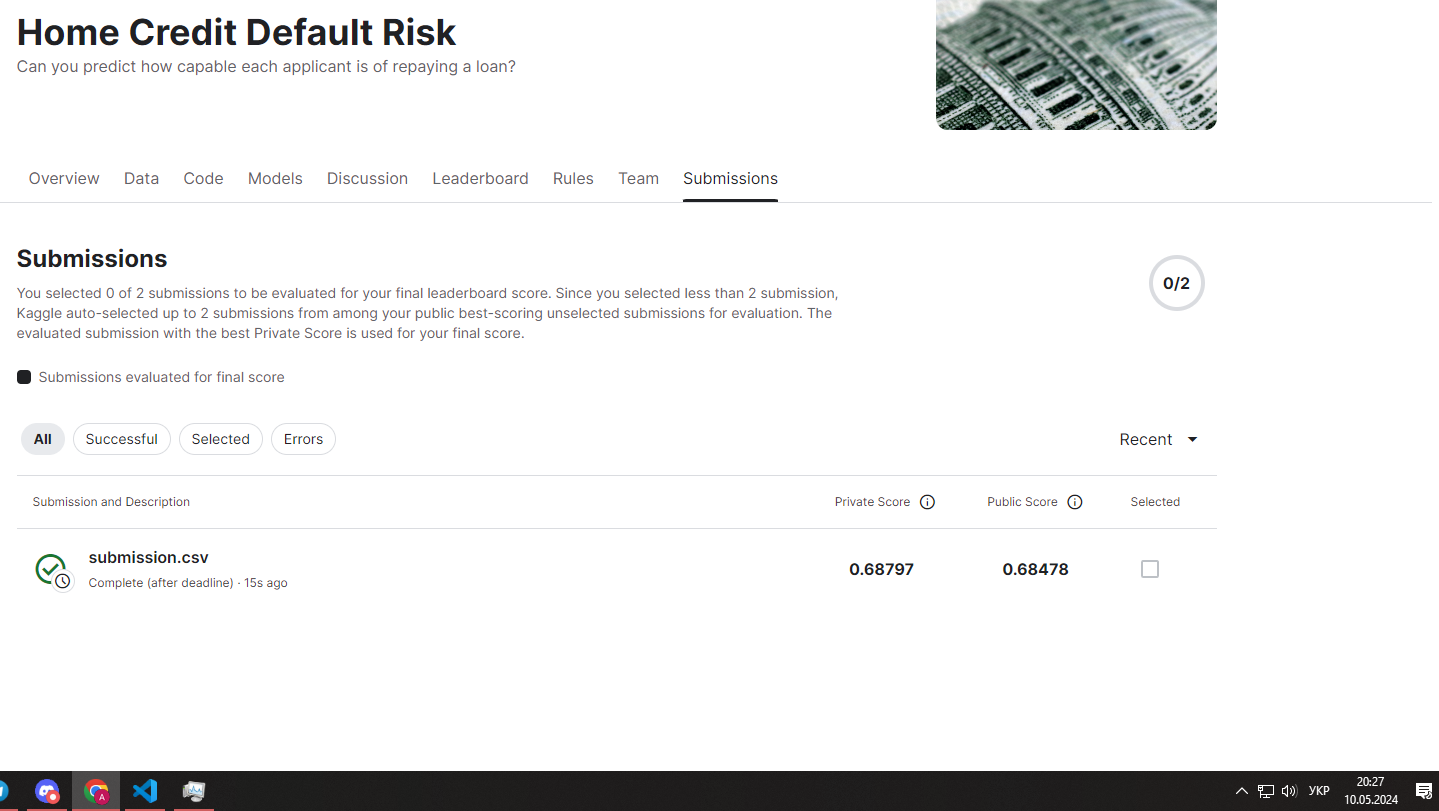